## Training autodifferentiated ODE fit

#### By: Sam Hocking

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import warnings

from cmlCore import *
from cmlUtils import *

np.set_printoptions(edgeitems=10, linewidth=100000, threshold=sys.maxsize)
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

from math import factorial
from copy import deepcopy

### Training task with autodifferentiated ODE fit

The standard training task to fit NVAR outputs to training data points with regularization is:

$$
\min_W \big\{\lVert HW - Y \rVert_2^2 + r \lVert W \rVert_2^2\big\}
$$

We add a term to train the NVAR model time derivative to the ODE:

$$
\min_W \big\{w_1 \lVert HW - Y \rVert_2^2 + w_{2} \lVert \frac{d\hat{Y}}{dt}-\frac{dY}{dt} \rVert_2^2  + r \lVert W \rVert_2^2\big\}
$$

For $t=\{\Delta t, 2\Delta t, \ldots, T\}$, each NVAR model time derivative is collected in the matrix

$$\frac{d\hat{Y}}{dt}=
\begin{bmatrix}
\frac{d\hat{\mathbf{y}}(\Delta t)}{dt} \\
\frac{d\hat{\mathbf{y}}(2\Delta t)}{dt} \\
\vdots \\
\frac{d\hat{\mathbf{y}}(T)}{dt}
\end{bmatrix}
=
\begin{bmatrix}
W^T\nabla h(\Delta t)\frac{\mathbf{h}_{lin}(\Delta t)}{dt} \\
W^T\nabla h(2\Delta t)\frac{\mathbf{h}_{lin}(2\Delta t)}{dt} \\
\vdots \\
W^T\nabla h(T)\frac{\mathbf{h}_{lin}(T)}{dt}
\end{bmatrix}
$$

We can further specify the tensor $P\in\mathbb{R}^{T\times m\times l}$ with entries $P_{ijk}$ where $m$ is the dimension of the model's state vector (model size) and $l=kd$ is the dimension of the linear portion of the state vector.

$$
P = 
\begin{bmatrix}
\nabla h(\Delta t) \\
\nabla h(2\Delta t) \\
\vdots \\
\nabla h(T)
\end{bmatrix}
$$

the matrix $Q\in\mathbb{R}^{T\times l}$ with entries $Q_{ik}$:

$$
Q = 
\begin{bmatrix}
\frac{\mathbf{h}_{lin}(\Delta t)}{dt} \\
\frac{\mathbf{h}_{lin}(2\Delta t)}{dt} \\
\vdots \\
\frac{\mathbf{h}_{lin}(T)}{dt}
\end{bmatrix}
$$

and see that the matrix $G\in\mathbb{R}^{T\times m}$ with entries $G_{ij}$

$$
G = 
\begin{bmatrix}
\nabla h(\Delta t)\frac{\mathbf{h}_{lin}(\Delta t)}{dt} \\
\nabla h(2\Delta t)\frac{\mathbf{h}_{lin}(2\Delta t)}{dt} \\
\vdots \\
\nabla h(T)\frac{\mathbf{h}_{lin}(T)}{dt}
\end{bmatrix}
$$

is given by the tensor contraction $G_{ij}=P_{ijk}Q_{ik}$ and we can write $\frac{d\hat{Y}}{dt}=GW$ so our training task is then:

$$
\min_W \big\{w_1 \lVert HW - Y \rVert_2^2 + w_{2} \lVert GW-\frac{dY}{dt} \rVert_2^2  + r \lVert W \rVert_2^2\big\}
$$

In [3]:
T = 300
dt = 0.01
d = 3

lorenz = np.loadtxt(f'./datasets/py-lorenz_RK4_T={T}_dt={dt}.csv', delimiter=",", dtype='float64')

data = lorenz[:,1:]
target = lorenz[1:,1:]

train_start=2000
# train_start=16500
# train_start=22000
train_end=26000
test_start=train_end
test_end=30000

training_target = target[train_start:train_end]
test_target = target[test_start:test_end]
train_indices = np.arange(train_start,train_end)
test_indices = np.arange(test_start,test_end)

dy_dt = simple_dlorenz()

#### We train two models: a "data-trained" model with only the data fit and regularization training, and an "ODE-trained" model with only the autodifferentiated ODE-fit and regularization training.

In [4]:
k = 6
s = 3
reg = 1e-4
# reg = 0

data_model = PolyCombNVARModel(k=k, s=s, reg=reg, max_order=2, d=3, natural_dt=dt)
ODE_model = PolyCombNVARModel(k=k, s=s, reg=reg, max_order=2, d=3, natural_dt=dt)

In [9]:
data_model.train(
        data,
        target,
        train_indices,
        dataLossFactor=1,
        ODELossFactor=0,
        ODEFunc=dy_dt,
        printResults=True
        )
ODE_model.train(
        data,
        target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.000000 0.000002      0.000002
ODE            0.000001 0.000000 0.000002 0.018287      0.000000
Regularization 0.001348 0.001348 0.036710 0.768148      0.000077
Total          0.001348 0.001348 0.036713 0.786438      0.000079
                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000000 0.000000 0.000002 0.000150      0.000000
ODE            0.000000 0.000000 0.000000 0.000142      0.000142
Regularization 0.001355 0.001355 0.036809 0.772289      0.000077
Total          0.001355 0.001355 0.036811 0.772580      0.000219


#### We compare the trained weights, first looking at the data-trained weights, then the ODE-trained weights, then the difference ODE-trained weights.

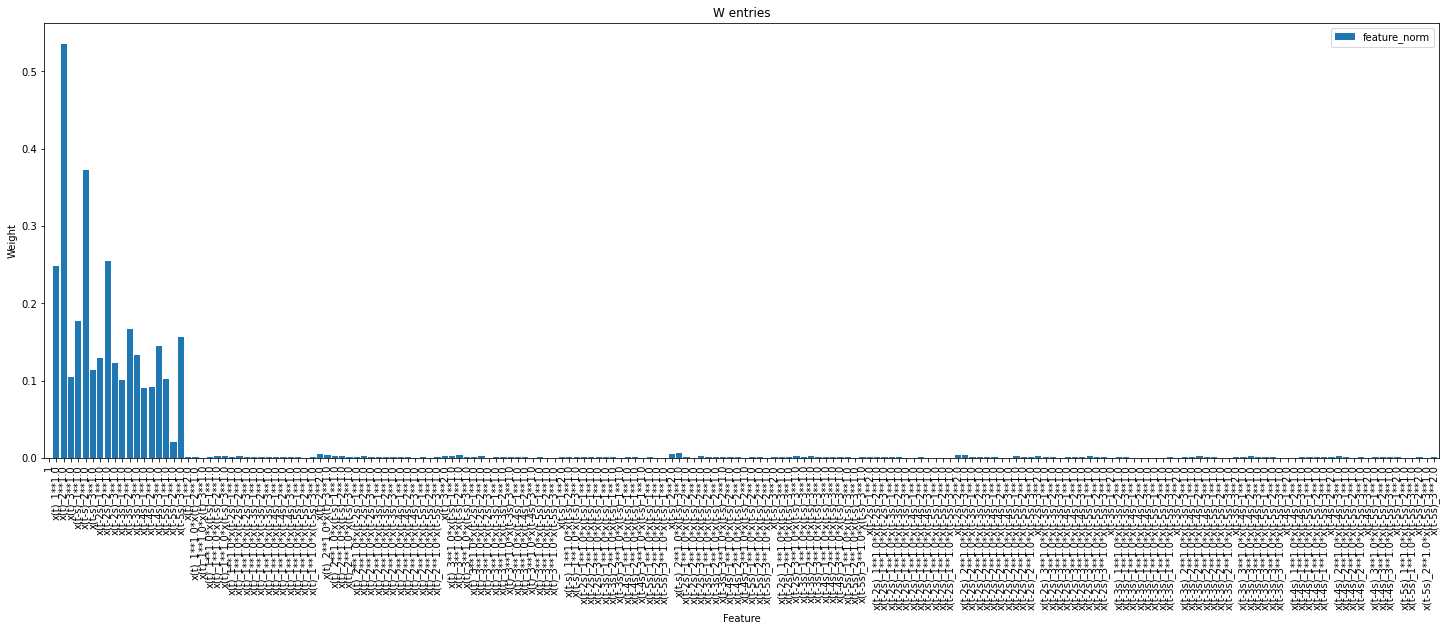

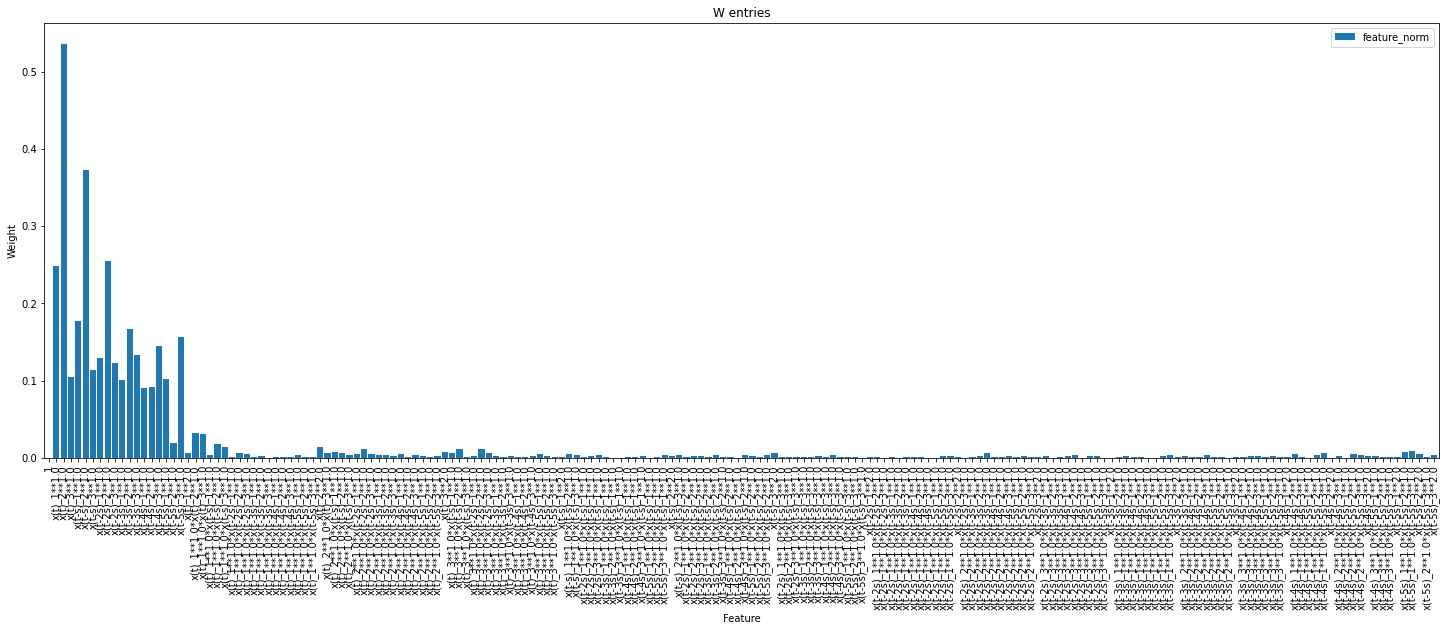

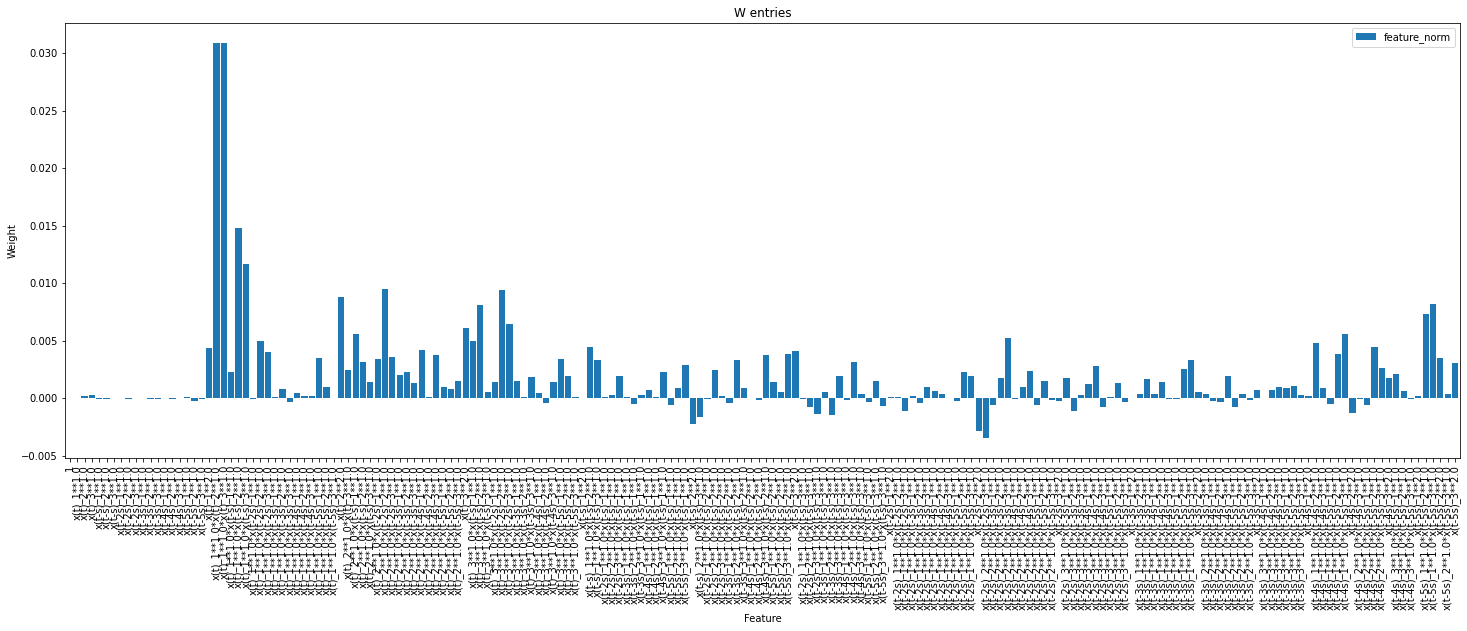

In [10]:
symb_state = get_symbolic_state_labels(
    k=k,
    d=d,
    nonlinearFunc = None,
    extraNonlinearFunc = None
)
linear = symb_state[symb_state[:,1]=='linear',0]

data_df = makeCombinedWeightDF(data_model.w, data_model.make_state_vector(linear))
ODE_df = makeCombinedWeightDF(ODE_model.w, ODE_model.make_state_vector(linear))
plotWeights(data_df)
plotWeights(ODE_df)

diff_df = deepcopy(ODE_df)
diff_df['feature_norm'] = ODE_df['feature_norm'] - data_df['feature_norm']
plotWeights(diff_df)

In [11]:
data_training_act_dydt = data_model.ODE_training_target
data_training_pred_dydt = data_model.G @ data_model.w

data_training_err = np.array([np.linalg.norm(data_training_pred_dydt[i]-data_training_act_dydt[i]) for i in range(len(train_indices))])
data_training_act_dydt_norm = np.array([np.linalg.norm(data_training_act_dydt[i]) for i in range(len(train_indices))])

ODE_training_act_dydt = ODE_model.ODE_training_target
ODE_training_pred_dydt = ODE_model.G @ ODE_model.w

ODE_training_err = np.array([np.linalg.norm(ODE_training_pred_dydt[i]-ODE_training_act_dydt[i]) for i in range(len(train_indices))])
ODE_training_act_dydt_norm = np.array([np.linalg.norm(ODE_training_act_dydt[i]) for i in range(len(train_indices))])

### ODE-fit for the data-trained model

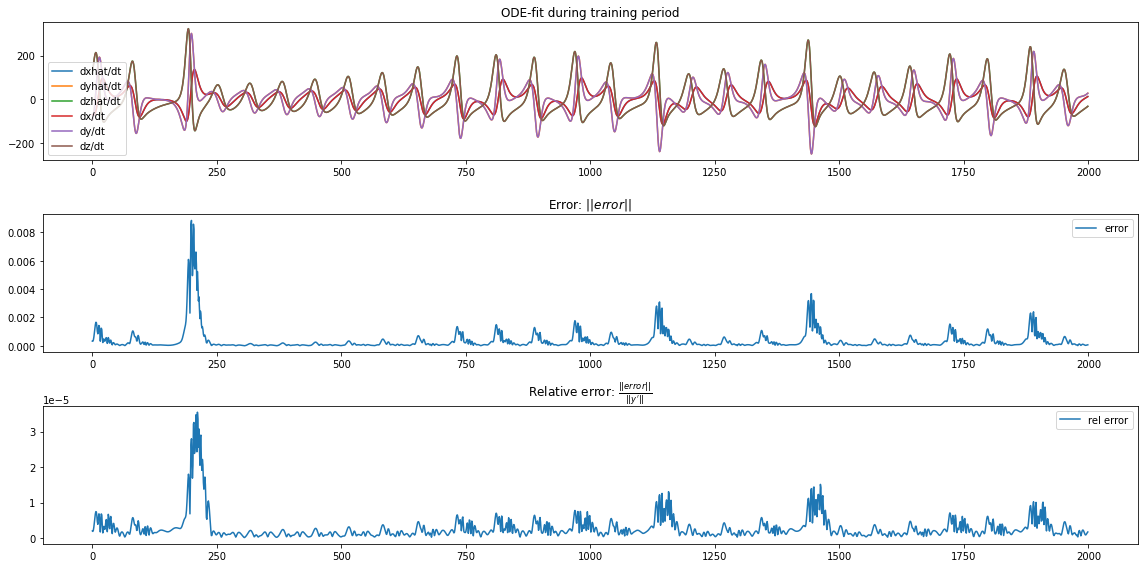

In [70]:
pts_to_show = 2000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(data_training_pred_dydt[:pts_to_show,0], label="dxhat/dt")
axs[0].plot(data_training_pred_dydt[:pts_to_show,1], label="dyhat/dt")
axs[0].plot(data_training_pred_dydt[:pts_to_show,2], label="dzhat/dt")
axs[0].plot(data_training_act_dydt[:pts_to_show,0], label="dx/dt")
axs[0].plot(data_training_act_dydt[:pts_to_show,1], label="dy/dt")
axs[0].plot(data_training_act_dydt[:pts_to_show,2], label="dz/dt")
axs[1].plot(data_training_err[:pts_to_show], label="error")
axs[2].plot(data_training_err[:pts_to_show]/data_training_act_dydt_norm[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('ODE-fit during training period')
axs[1].set_title(r'Error: $|| error ||$')
axs[2].set_title(r"Relative error: $\frac{|| error ||}{||y'||}$")
fig.tight_layout()
plt.show()

valid time : 1038


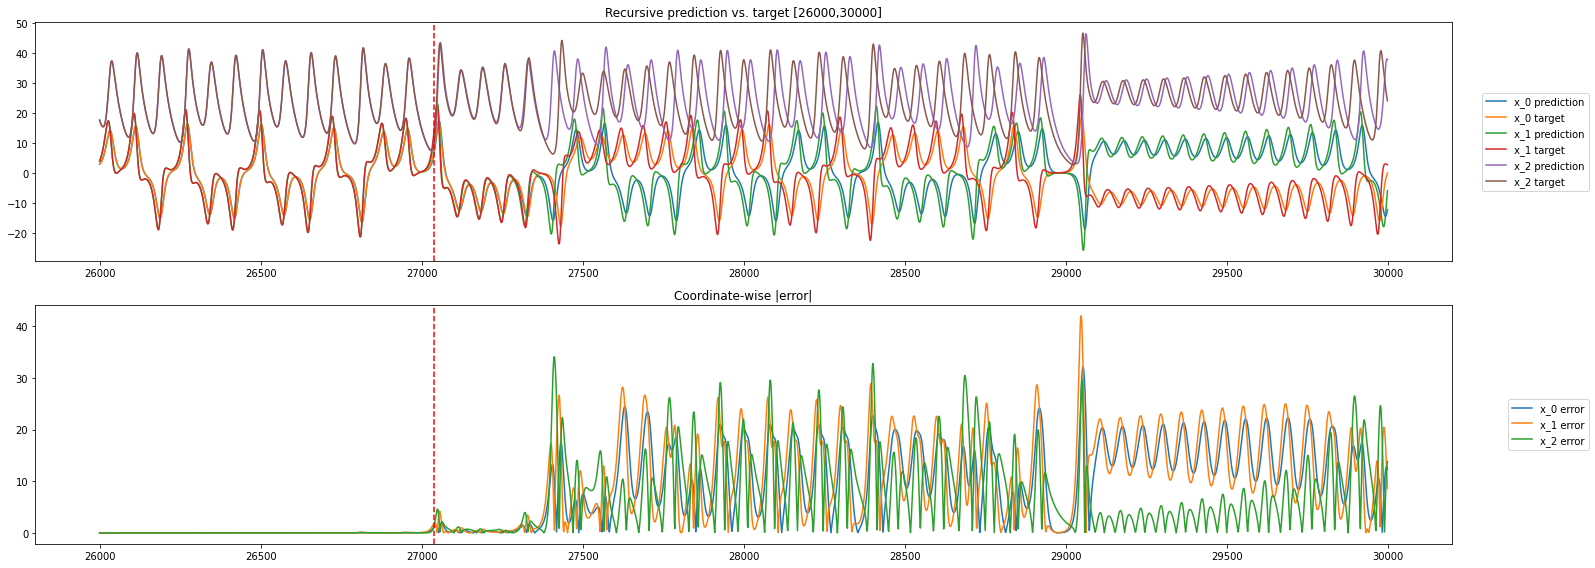

In [13]:
t_forward = 4000
data_recursive_out = data_model.recursive_predict(data, train_start, train_end, t_forward)
data_rec_y = data_recursive_out.y
data_rec_dydt = data_recursive_out.dydt
data_act_dydt = np.array([dy_dt(x) for x in data_rec_y])
data_err = data_act_dydt - data_rec_dydt
data_err_norm = np.array([np.linalg.norm(x) for x in data_err])

vt = validTime(0.2)(data_rec_y, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
plotRecursiveComparison(data_rec_y, data, train_end, t_forward, vline_x=test_start+vt)

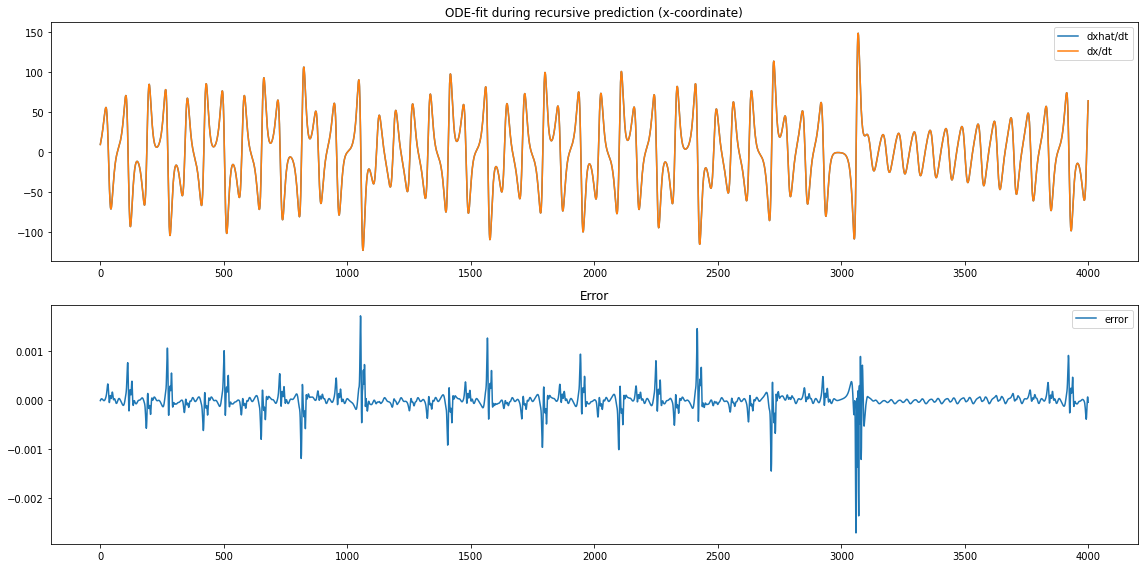

In [72]:
pts_to_show = 4000

fig, axs = plt.subplots(2, figsize=(16,8))
axs[0].plot(data_rec_dydt[:pts_to_show,0], label="dxhat/dt")
axs[0].plot(data_act_dydt[:pts_to_show,0], label="dx/dt")
axs[1].plot(data_err[:pts_to_show,0], label="error")
axs[0].legend()
axs[1].legend()
axs[0].set_title('ODE-fit during recursive prediction (x-coordinate)')
axs[1].set_title(r'Error')
fig.tight_layout()
plt.show()

### ODE-fit for the ODE-trained model

#### The maximum ODE-fit error during training is about one order of magnitude less than the data-trained model. Notice the recursive data-fit is worse (valid for about 250 fewer time steps), which is not unexpected.

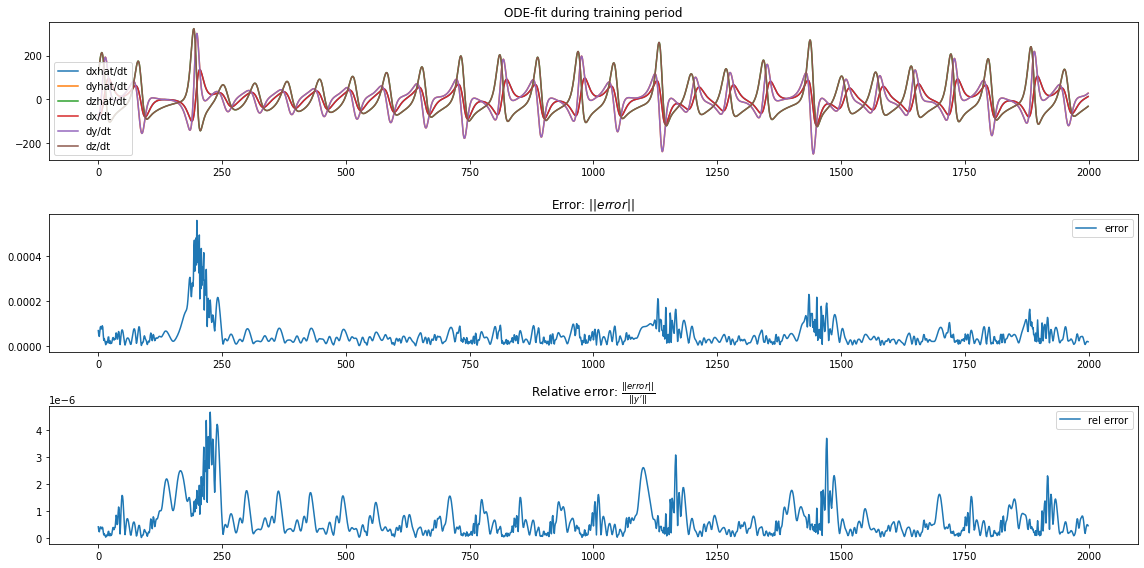

In [69]:
pts_to_show = 2000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(ODE_training_pred_dydt[:pts_to_show,0], label="dxhat/dt")
axs[0].plot(ODE_training_pred_dydt[:pts_to_show,1], label="dyhat/dt")
axs[0].plot(ODE_training_pred_dydt[:pts_to_show,2], label="dzhat/dt")
axs[0].plot(ODE_training_act_dydt[:pts_to_show,0], label="dx/dt")
axs[0].plot(ODE_training_act_dydt[:pts_to_show,1], label="dy/dt")
axs[0].plot(ODE_training_act_dydt[:pts_to_show,2], label="dz/dt")
axs[1].plot(ODE_training_err[:pts_to_show], label="error")
axs[2].plot(ODE_training_err[:pts_to_show]/ODE_training_act_dydt_norm[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
axs[0].set_title('ODE-fit during training period')
axs[1].set_title(r'Error: $|| error ||$')
axs[2].set_title(r"Relative error: $\frac{|| error ||}{||y'||}$")
fig.tight_layout()
plt.show()

valid time : 783


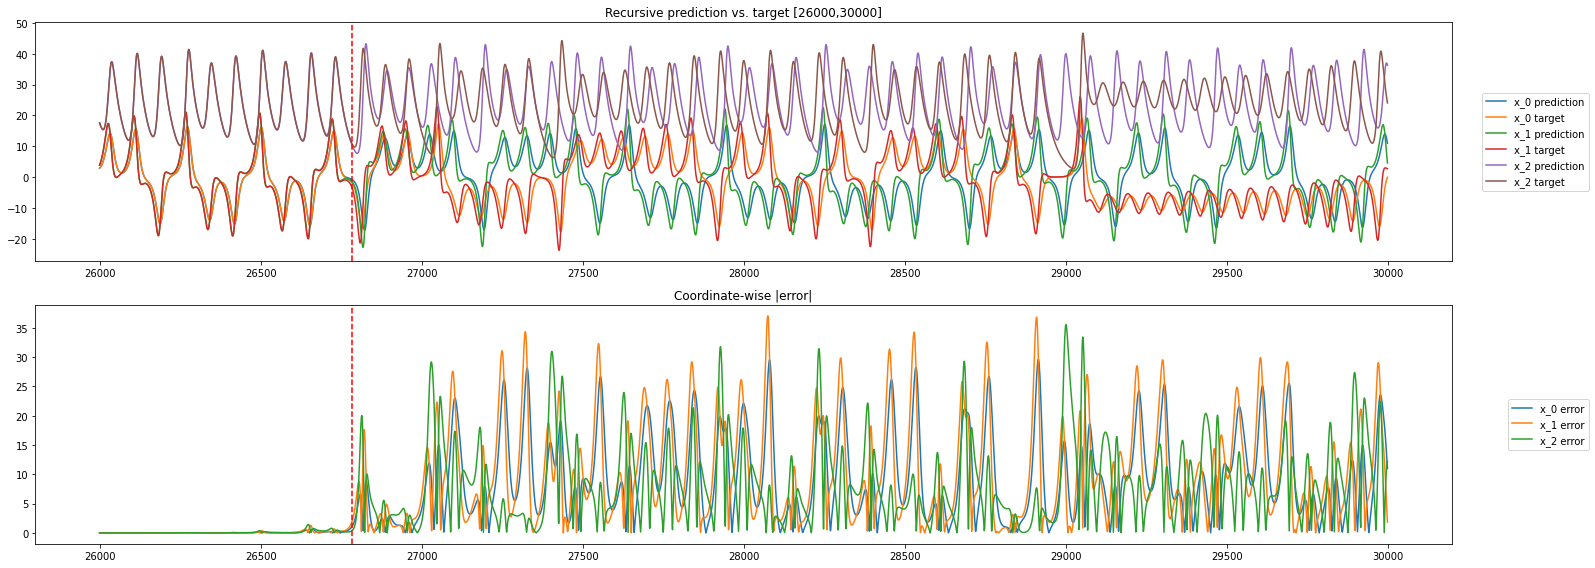

In [73]:
t_forward = 4000
recursive_out = ODE_model.recursive_predict(data, train_start, train_end, t_forward)
ODE_rec_y = recursive_out.y
ODE_rec_dydt = recursive_out.dydt
ODE_act_dydt = np.array([dy_dt(x) for x in ODE_rec_y])
ODE_err = ODE_act_dydt - ODE_rec_dydt
ODE_err_norm = np.array([np.linalg.norm(x) for x in ODE_err])

vt = validTime(0.2)(ODE_rec_y, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
# print(f'NMSE       : {NMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'RMSE       : {RMSE(recursive_out, target[test_start:test_start+t_forward])}')
# print(f'NRMSE      : {NRMSE(recursive_out, target[test_start:test_start+t_forward])}')
plotRecursiveComparison(ODE_rec_y, data, train_end, t_forward, vline_x=test_start+vt)

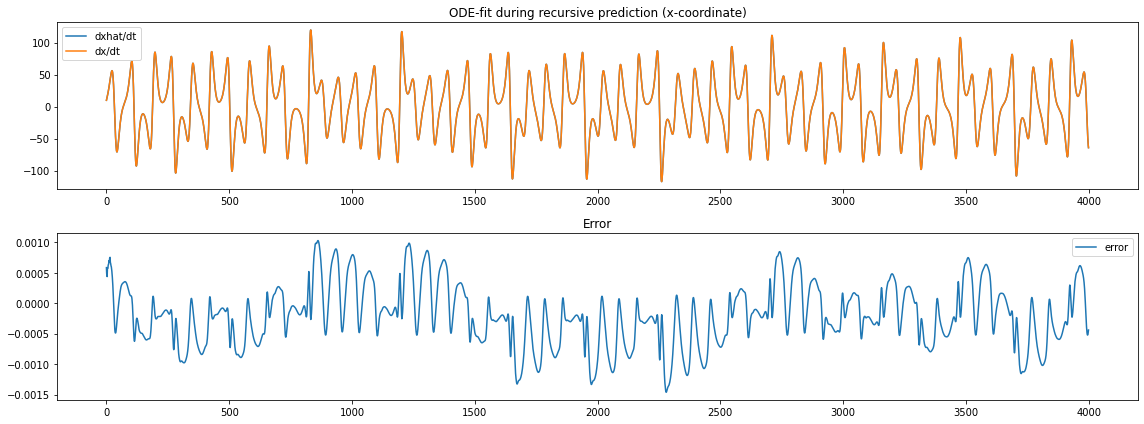

In [77]:
pts_to_show = 4000

fig, axs = plt.subplots(2, figsize=(16,6))
axs[0].plot(ODE_rec_dydt[:pts_to_show,0], label="dxhat/dt")
axs[0].plot(ODE_act_dydt[:pts_to_show,0], label="dx/dt")
axs[1].plot(ODE_err[:pts_to_show,0], label="error")
axs[0].legend()
axs[1].legend()
axs[0].set_title('ODE-fit during recursive prediction (x-coordinate)')
axs[1].set_title(r'Error')
fig.tight_layout()
plt.show()

#### Interestingly, despite the ODE-trained model achieving better ODE-fit during training (as expected/hoped), the ODE-fit is worse during recursive prediction.

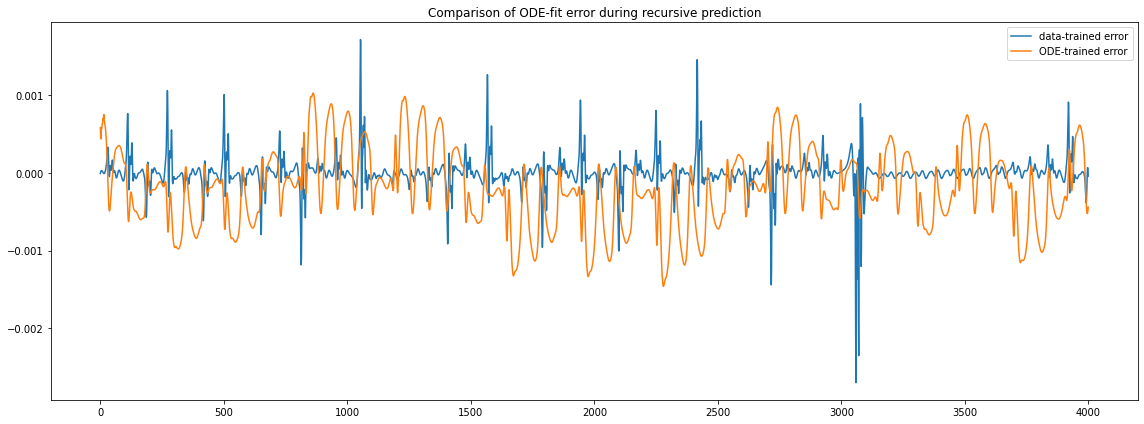

In [74]:
pts_to_show = 4000

fig, axs = plt.subplots(1, figsize=(16,6))
axs.plot(data_err[:pts_to_show,0], label="data-trained error")
axs.plot(ODE_err[:pts_to_show,0], label="ODE-trained error")
axs.legend()
axs.set_title('Comparison of ODE-fit error during recursive prediction')
fig.tight_layout()
plt.show()

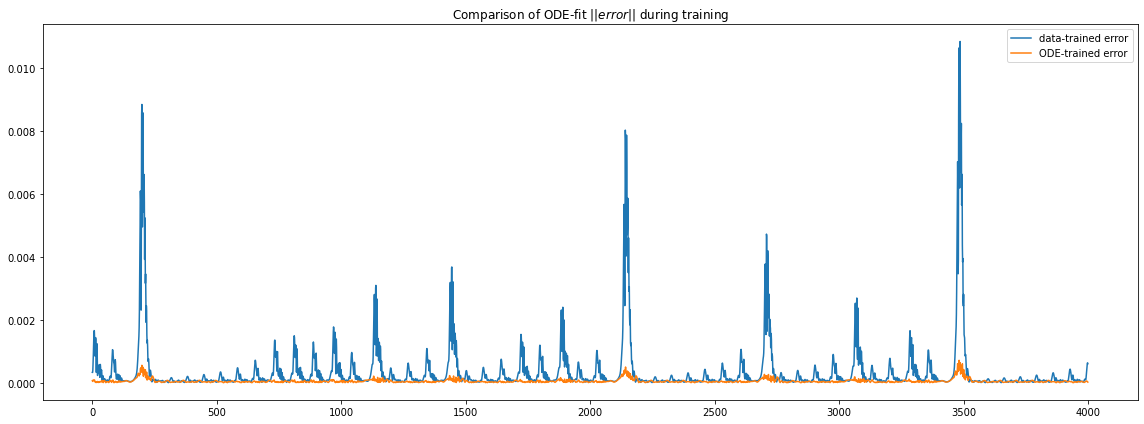

In [75]:
pts_to_show = 4000

fig, axs = plt.subplots(1, figsize=(16,6))
axs.plot(data_training_err[:pts_to_show], label="data-trained error")
axs.plot(ODE_training_err[:pts_to_show], label="ODE-trained error")
axs.legend()
axs.set_title(r'Comparison of ODE-fit $||error||$ during training')
fig.tight_layout()
plt.show()

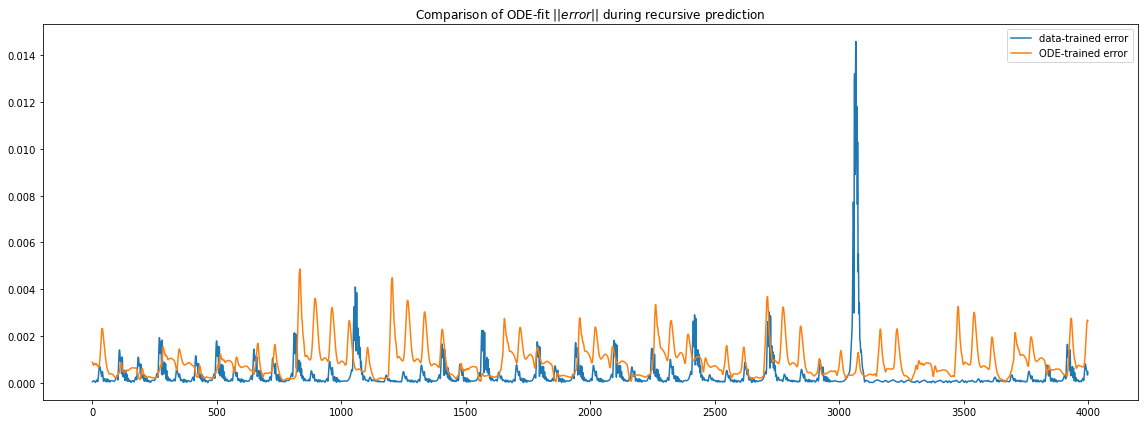

In [78]:
pts_to_show = 4000

fig, axs = plt.subplots(1, figsize=(16,6))
axs.plot(data_err_norm[:pts_to_show], label="data-trained error")
axs.plot(ODE_err_norm[:pts_to_show], label="ODE-trained error")
axs.legend()
axs.set_title(r'Comparison of ODE-fit $||error||$ during recursive prediction')
fig.tight_layout()
plt.show()

In [45]:
print('ODE-fit loss')
print(' Training:')
print(f'  Data-trained model : {np.linalg.norm(data_training_err)**2}')
print(f'  ODE-trained model  : {np.linalg.norm(ODE_training_err)**2}')
print('')
print(' Recursive prediction:')
print(f'  Data-trained model : {np.linalg.norm(data_err)**2}')
print(f'  ODE-trained model  : {np.linalg.norm(ODE_err)**2}')

ODE-fit loss
 Training:
  Data-trained model : 0.018287339552510874
  ODE-trained model  : 0.00014188060241910428

 Recursive prediction:
  Data-trained model : 0.003200532240096557
  ODE-trained model  : 0.005268370947297692


## Trying higher order nonlinear combinations
### (quick takeaway: these models are not stable and produce recursive predictions that blow up very quickly)

#### Cubic combinations

In [24]:
cubic_model = PolyCombNVARModel(k=4, s=3, reg=1e-7, max_order=3, d=3, natural_dt=dt)

In [25]:
cubic_model.train(
        data,
        target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=dy_dt,
        printResults=True
        )

                    MSE     NMSE    NRMSE     Loss Weighted Loss
Component                                                       
Data           0.000055 0.000000 0.000161 1.313626      0.000000
ODE            0.000023 0.000000 0.000014 0.562956      0.562956
Regularization 0.000635 0.000635 0.025192 0.866313      0.000000
Total          0.000713 0.000635 0.025367 2.742896      0.562956


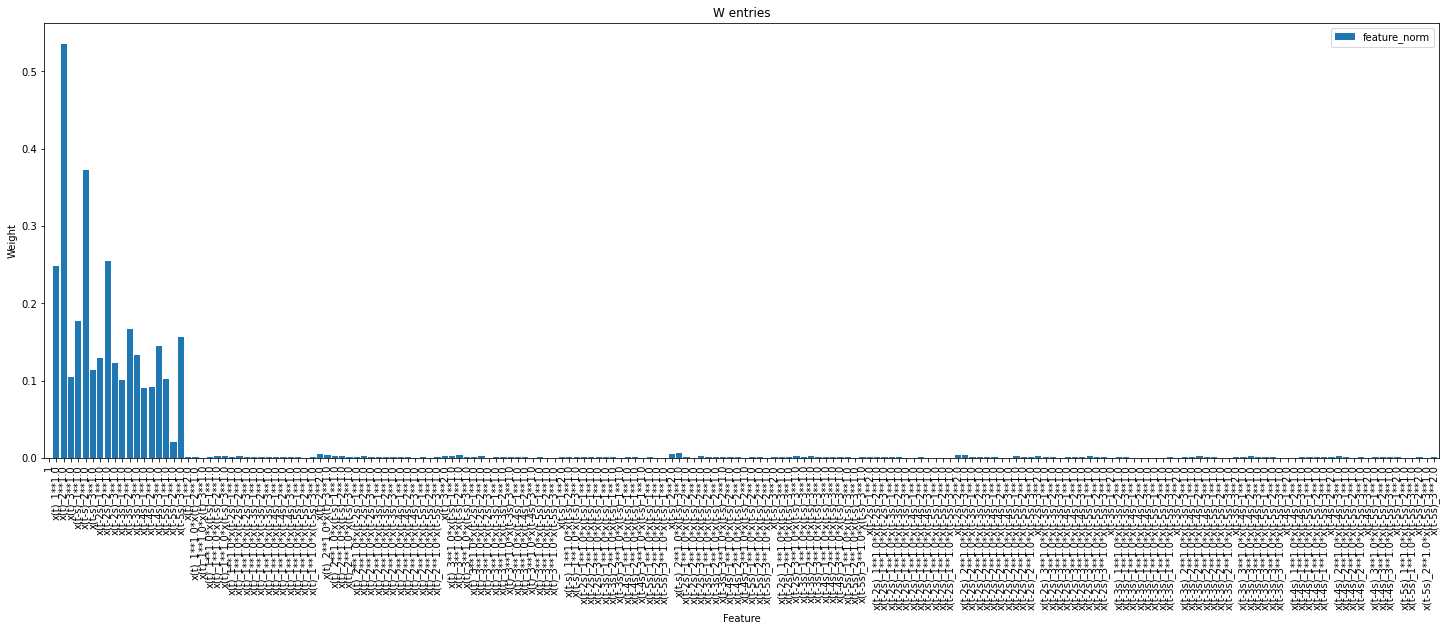

In [26]:
symb_state = get_symbolic_state_labels(
    k=4,
    d=d,
    nonlinearFunc = None,
    extraNonlinearFunc = None
)
linear = symb_state[symb_state[:,1]=='linear',0]

# df = makeCombinedWeightDF(model.w, np.vstack((model.make_state_vector(linear),np.ones(len(model.w)))).T)
cubic_df = makeCombinedWeightDF(cubic_model.w, cubic_model.make_state_vector(linear))
plotWeights(data_df)

In [27]:
cubic_training_act_dydt = cubic_model.ODE_training_target
cubic_training_pred_dydt = cubic_model.G @ cubic_model.w

cubic_training_err = np.array([np.linalg.norm(cubic_training_pred_dydt[i]-cubic_training_act_dydt[i]) for i in range(len(train_indices))])
cubic_training_act_dydt_norm = np.array([np.linalg.norm(cubic_training_act_dydt[i]) for i in range(len(train_indices))])

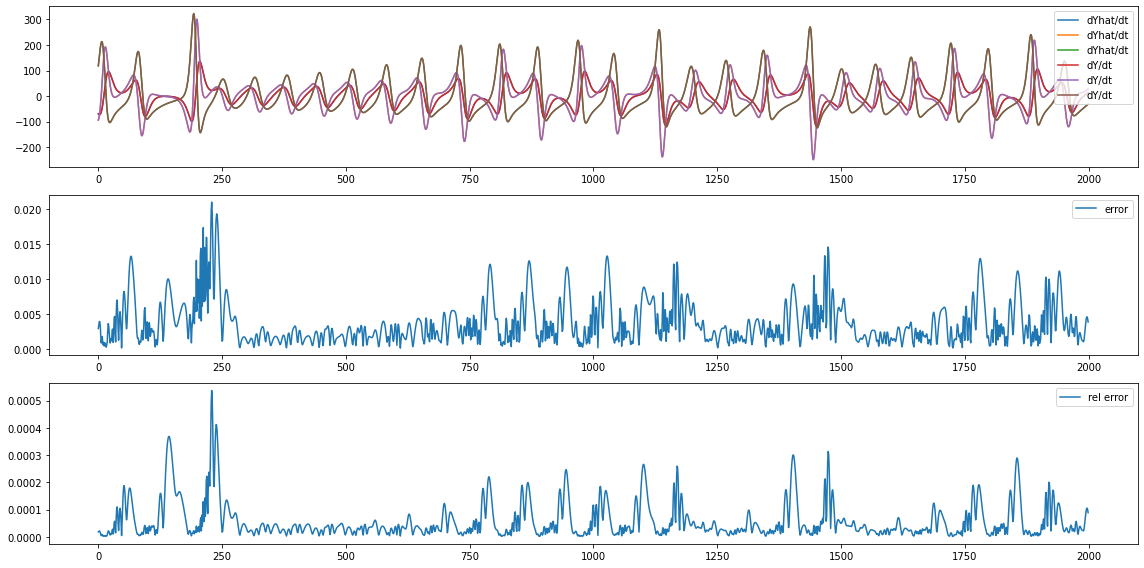

In [28]:
pts_to_show = 2000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(cubic_training_pred_dydt[:pts_to_show], label="dYhat/dt")
axs[0].plot(cubic_training_act_dydt[:pts_to_show], label="dY/dt")
axs[1].plot(cubic_training_err[:pts_to_show], label="error")
axs[2].plot(cubic_training_err[:pts_to_show]/cubic_training_act_dydt_norm[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

valid time : 24


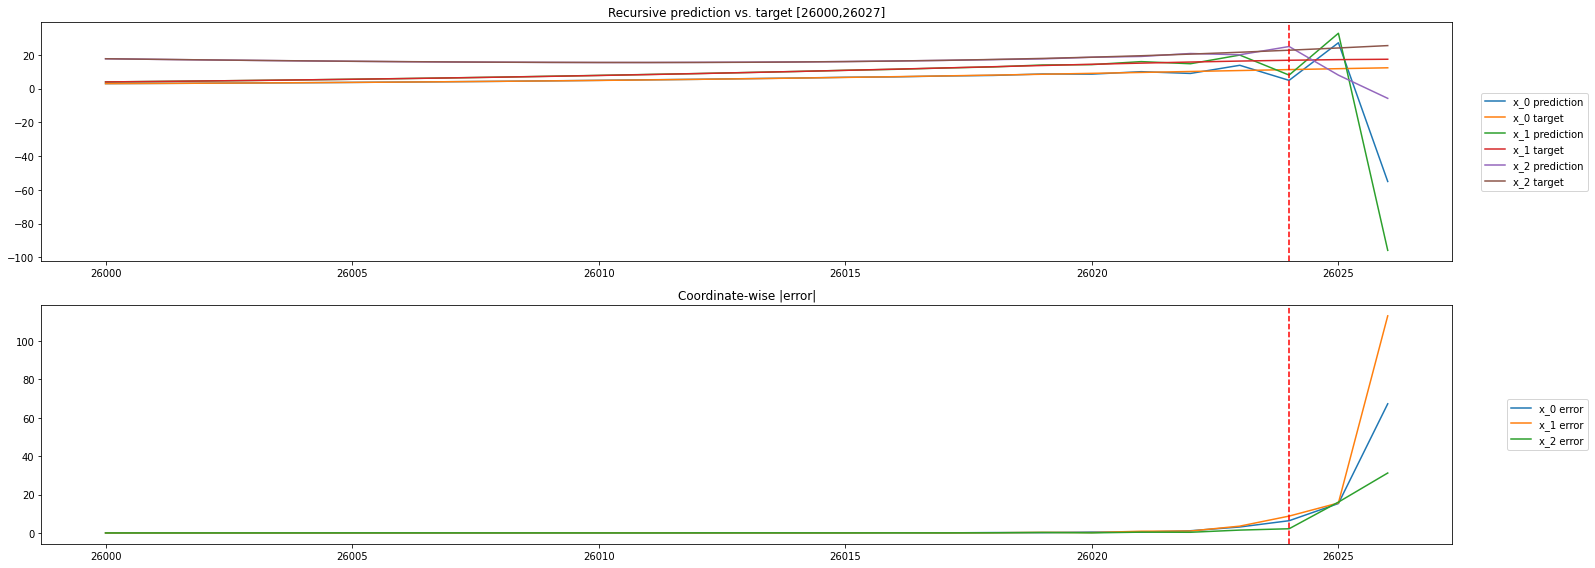

In [31]:
t_forward = 27
cubic_recursive_out = cubic_model.recursive_predict(data, train_start, train_end, t_forward)
cubic_rec_y = cubic_recursive_out.y
cubic_rec_dydt = cubic_recursive_out.dydt
cubic_act_dydt = np.array([dy_dt(x) for x in cubic_rec_y])
cubic_err = cubic_act_dydt - cubic_rec_dydt
cubic_err_norm = np.array([np.linalg.norm(x) for x in cubic_err])

vt = validTime(0.2)(cubic_rec_y, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
plotRecursiveComparison(cubic_rec_y, data, train_end, t_forward, vline_x=test_start+vt)

#### Quartic combinations

In [32]:
quartic_model = PolyCombNVARModel(k=4, s=3, reg=1e-7, max_order=4, d=3, natural_dt=dt)

In [33]:
quartic_model.train(
        data,
        target,
        train_indices,
        dataLossFactor=0,
        ODELossFactor=1,
        ODEFunc=dy_dt,
        printResults=True
        )

                     MSE     NMSE    NRMSE          Loss Weighted Loss
Component                                                             
Data            7.002178 0.009023 0.057710 168052.269342      0.000000
ODE             6.176918 0.000517 0.006960 148246.030714 148246.030714
Regularization  0.000003 0.000003 0.001587      0.013748      0.000000
Total          13.179098 0.009543 0.066257 316298.313805 148246.030714


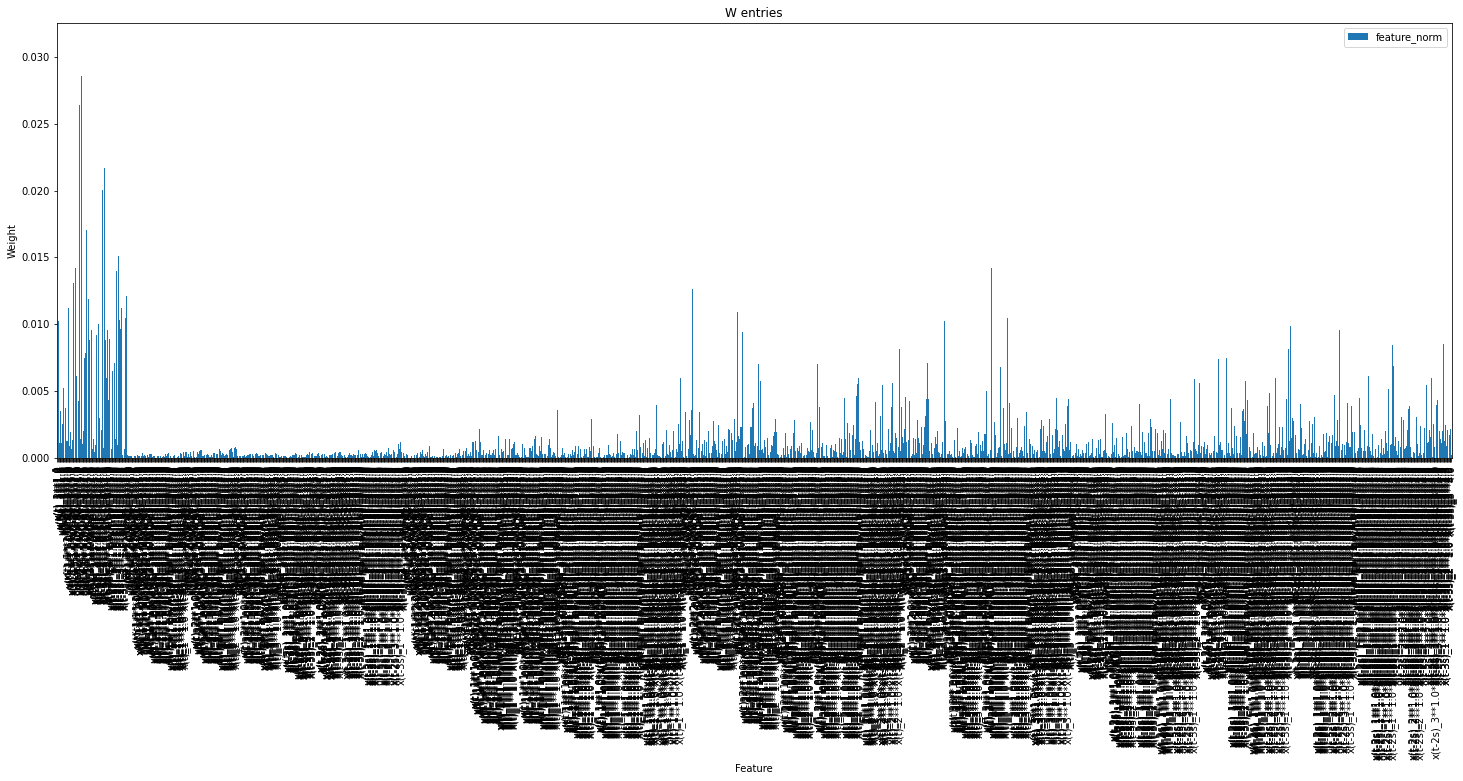

In [34]:
quartic_df = makeCombinedWeightDF(quartic_model.w, quartic_model.make_state_vector(linear))
plotWeights(quartic_df)

In [35]:
quartic_training_act_dydt = quartic_model.ODE_training_target
quartic_training_pred_dydt = quartic_model.G @ quartic_model.w

quartic_training_err = np.array([np.linalg.norm(quartic_training_pred_dydt[i]-quartic_training_act_dydt[i]) for i in range(len(train_indices))])
quartic_training_act_dydt_norm = np.array([np.linalg.norm(quartic_training_act_dydt[i]) for i in range(len(train_indices))])

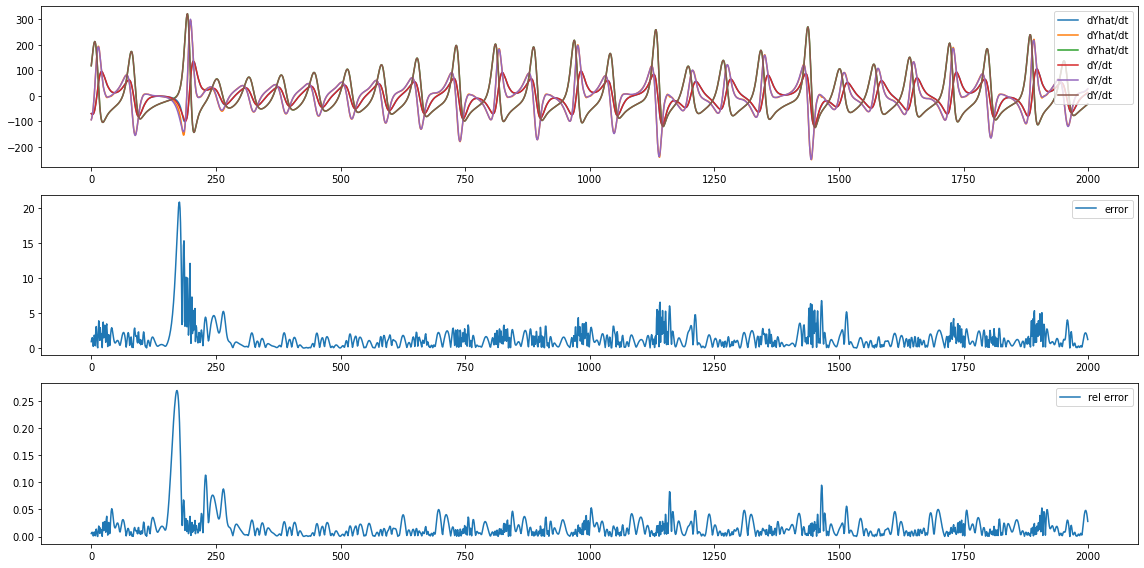

In [36]:
pts_to_show = 2000
fig, axs = plt.subplots(3, figsize=(16,8))
axs[0].plot(quartic_training_pred_dydt[:pts_to_show], label="dYhat/dt")
axs[0].plot(quartic_training_act_dydt[:pts_to_show], label="dY/dt")
axs[1].plot(quartic_training_err[:pts_to_show], label="error")
axs[2].plot(quartic_training_err[:pts_to_show]/quartic_training_act_dydt_norm[:pts_to_show], label="rel error")
axs[0].legend()
axs[1].legend()
axs[2].legend()
fig.tight_layout()
plt.show()

valid time : 1


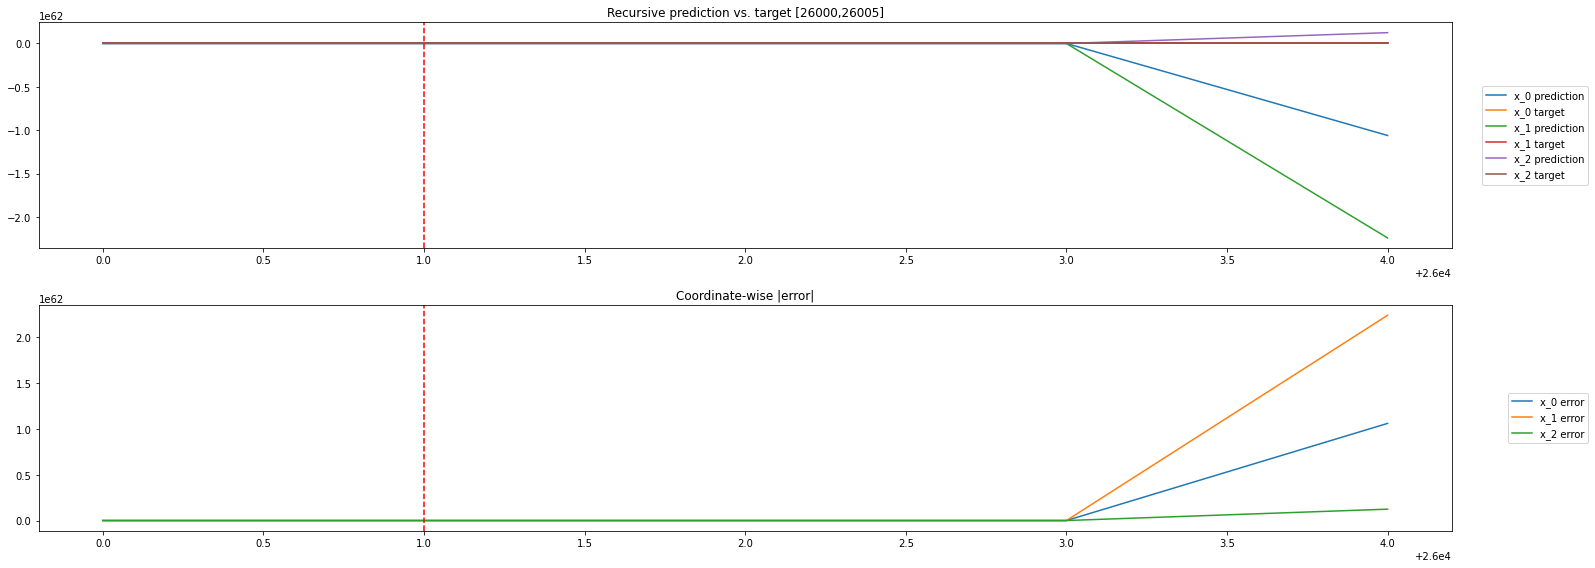

In [39]:
t_forward = 5
quartic_recursive_out = quartic_model.recursive_predict(data, train_start, train_end, t_forward)
quartic_rec_y = quartic_recursive_out.y
quartic_rec_dydt = quartic_recursive_out.dydt
quartic_act_dydt = np.array([dy_dt(x) for x in quartic_rec_y])
quartic_err = quartic_act_dydt - quartic_rec_dydt
quartic_err_norm = np.array([np.linalg.norm(x) for x in quartic_err])

vt = validTime(0.2)(quartic_rec_y, target[test_start:test_start+t_forward])

print(f'valid time : {vt}')
plotRecursiveComparison(quartic_rec_y, data, train_end, t_forward, vline_x=test_start+vt)

## Parameter Search

In [ ]:
# want to add a metric for testing loss on obj funvc
testRecursiveNVARParams_Poly(
    k=4,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    metricFunc=validTime(0.2),
    max_order=2,
    objective=np.argmax,
    dataLossFactor=0,
    ODELossFactor=1,
    ODEFunc=dy_dt,
    natural_dt=dt
)

done: scen 55/55 (100.00%) |  s=10 r=0.1 metric=10
best recursive params:
k        :4
s        :2
reg      :0.1
objective:742


In [ ]:
# want to add a metric for testing loss on obj funvc
testRecursiveNVARParams_Poly(
    k=6,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    metricFunc=validTime(0.2),
    max_order=2,
    objective=np.argmax,
    dataLossFactor=0,
    ODELossFactor=1,
    ODEFunc=dy_dt,
    natural_dt=dt
)

done: scen 55/55 (100.00%) |  s=10 r=0.1 metric=14
best recursive params:
k        :6
s        :3
reg      :0.0001
objective:1131


In [ ]:
# want to add a metric for testing loss on obj funvc
testRecursiveNVARParams_Poly(
    k=8,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    metricFunc=validTime(0.2),
    max_order=2,
    objective=np.argmax,
    dataLossFactor=0,
    ODELossFactor=1,
    ODEFunc=dy_dt,
    natural_dt=dt
)

done: scen 55/55 (100.00%) |  s=10 r=0.1 metric=69
best recursive params:
k        :8
s        :2
reg      :1e-07
objective:757


In [ ]:
# want to add a metric for testing loss on obj funvc
testRecursiveNVARParams_Poly(
    k=4,
    s_grid=[2,3,4,5,6,7,8,10],
    reg_grid=[1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1],
    data=data,
    target=target,
    train_start=train_start,
    train_end=train_end,
    test_start=test_start,
    test_end=test_end,
    metricFunc=validTime(0.2),
    max_order=3,
    objective=np.argmax,
    dataLossFactor=0,
    ODELossFactor=1,
    ODEFunc=dy_dt,
    natural_dt=dt
)

done: scen 55/55 (100.00%) |  s=10 r=0.1 metric=5
best recursive params:
k        :4
s        :3
reg      :1e-07
objective:7
